# Loading Data

In [1]:
import pandas as pd

In [2]:
tweet = pd.read_csv('./Prepocessing_Data/TweetClean.csv')
tweet.head()

,Unnamed: 0,Tweet,TweetClean_NonPT,TweetClean_PT
0,0,Udah ngeh blm min?\r\nItu sms 86mb jam 16.06 t...,sadar min sms mb jam tanggal kemarin paketin t...,sadar min sms mb jam tanggal kemarin paketin t...
1,1,Dibaca itu yang kemarin min 86 mb... Pas jam 1...,dibaca kemarin min mb jam paketin,dibaca kemarin min mb jam paketin
2,2,@IndosatCare pusing saya min pake indosat... \...,pusing min kuota,pusing min kuota
3,3,"Sudah min sudah, lagian apa yang mau di clear ...",min dibilang diuninstal diinstal sebulan min k...,min dibilang diuninstal diinstal sebulan min k...
4,4,"@IndosatCare masi juga lelet euy,, apakah bts ...",masi didaerah karna kantor,masi didaerah karna kantor


In [54]:
listTweet=tweet['TweetClean_NonPT'].values.astype('U')
listTweet = [d for d in listTweet]

In [56]:
tweeet=listTweet

In [77]:
len(tweeet)

4359

In [66]:
D = ' '.join([tweeet[i] for i in range(len(tweeet))])

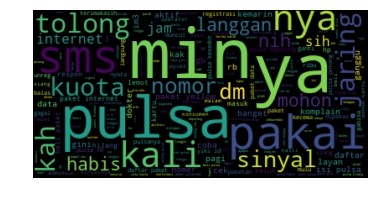

In [70]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(D)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# MODEL VSM TFIdf

In [4]:
#Pembentukan Model VSM tanpa PosTag

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

Tfidf_vectorizer = TfidfVectorizer(max_df=0.75, min_df=5)
X = Tfidf_vectorizer.fit_transform(listTweet)
X_term = Tfidf_vectorizer.get_feature_names()
print(X.shape)

(4359, 1192)


In [5]:
import numpy as np
#menghapus tfidf yang bernilai 0
nidx = np.array(range(len(listTweet)))
nidx = nidx[X.getnnz(1)>0] # Remove Zero Rows
data_bersih = [listTweet[i] for i in nidx]
X = X[X.getnnz(1)>0] # Remove Zero Rows
X_terms = Tfidf_vectorizer.get_feature_names()
print(X.shape)

(4330, 1192)


# Percobaan berbagai Model

## K-Means ++

In [6]:
from sklearn import cluster
from tqdm import tqdm

seed = 99 #harus ditetapkan untuk mengoptimalkan cost function 
#atau untuk konvergen lebih cepat aja dalam pengelompokannya, 
#tidak ada hubungan antara nilai pasti dari seed dan hasil pengelompokan KMeans
#seed ini harus ditentukan terlebih dahulu agar tidak menghasilkan pengelompokan yg berbeda setiap dijalankan aja
C=[]
K=[] 
kelompok = []
for k in tqdm(range(2,9)):
    kelompok.append(k)
    kmPP = cluster.KMeans(n_clusters=k, init='k-means++', max_iter=300, tol=0.0001, n_jobs=-1, random_state = seed)
    K.append(kmPP.fit(X))
    C.append(kmPP.predict(X))

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [05:50<00:00, 50.02s/it]


In [7]:
#Evaluasi : Internal . Contoh Silouette Coefficient ==> warning hanya cocok untuk k-means/menggunakan centroid
from sklearn.metrics import silhouette_score as siluet

ScoreSiluet=[]
i=int(kelompok[0])
for res in C:
    ScoreSiluet.append(siluet(X,res))
    print("K={} ,nilai siluet {} ".format(i, siluet(X,res)))
    i=i+1
print("dengan score terbesar {}".format(max(ScoreSiluet)))    

K=2 ,nilai siluet 0.008438239188252877 
K=3 ,nilai siluet 0.011281438684816205 
K=4 ,nilai siluet 0.01089550959853382 
K=5 ,nilai siluet 0.012496563512651658 
K=6 ,nilai siluet 0.013110989913968493 
K=7 ,nilai siluet 0.013756624705761372 
K=8 ,nilai siluet 0.014431507855871354 
dengan score terbesar 0.014431507855871354


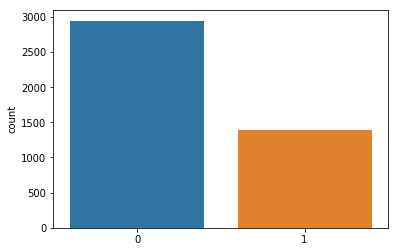

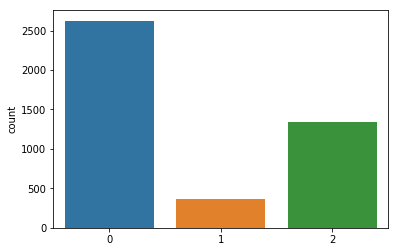

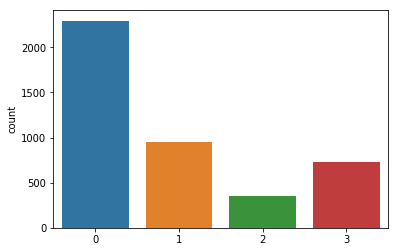

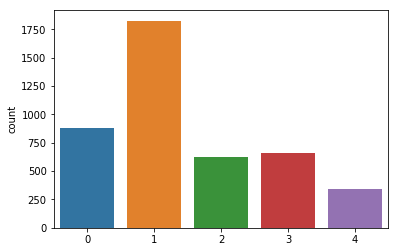

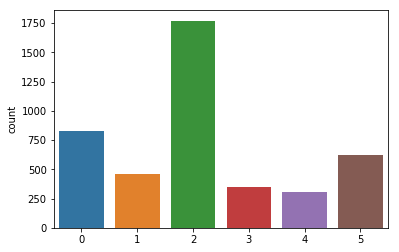

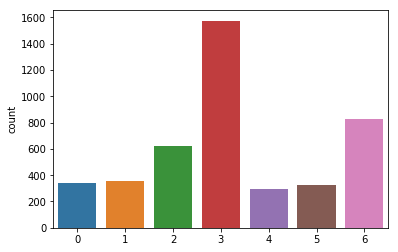

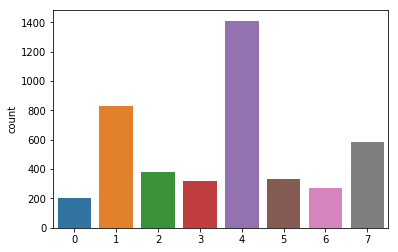

In [76]:
#dengan 9 Kluster yang menurut Evaluasi secara internal terbaik 
import seaborn as sns
import matplotlib.pyplot as plt

for i in C:
    sns.countplot(i)
    plt.show()

## Mini Batch K-Means++

In [9]:
from sklearn import cluster
from tqdm import tqdm

# MiniBatch k-Means 
# http://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html
# minibatch "tidak bisa parallel"!!!...
# parameter penting km = batch_size ... pada aplikasi sesungguhnya disarankan "minimal" 3xk

seed = 99 #harus ditetapkan untuk mengoptimalkan cost function 
#atau untuk konvergen lebih cepat aja dalam pengelompokannya, 
#tidak ada hubungan antara nilai pasti dari seed dan hasil pengelompokan KMeans
#seed ini harus ditentukan terlebih dahulu agar tidak menghasilkan pengelompokan yg berbeda setiap dijalankan aja
Cmb=[]
Kmb=[] 
kelompokMb = []
for k in tqdm(range(2,9)):
    kelompokMb.append(k)
    MiniBatchKM = cluster.MiniBatchKMeans(n_clusters=k, init='k-means++', max_iter=300,batch_size=10 , tol=0.0001, random_state = seed) 
    Kmb.append(MiniBatchKM.fit(X))
    Cmb.append(MiniBatchKM.predict(X))

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.18s/it]


In [78]:
Cmb[0]

array([0, 1, 0, ..., 0, 1, 1])

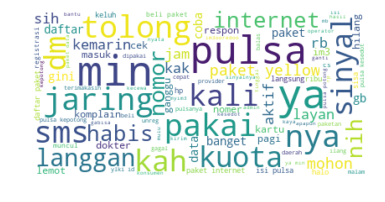

In [75]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

n_cluster=2
cluster = 1 # misal cluster pertama
hasilcluster=Cmb

idx = [i for i,c in enumerate(hasilcluster[n_cluster-2]) if c==cluster]
teks_cluster = ' '.join([listTweet[i] for i in idx])

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(teks_cluster)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [10]:
#Evaluasi : Internal . Contoh Silouette Coefficient ==> warning hanya cocok untuk k-means/menggunakan centroid
from sklearn.metrics import silhouette_score as siluet

ScoreSiluet=[]
i=int(kelompok[0])
for res in Cmb:
    ScoreSiluet.append(siluet(X,res))
    print("K={} ,nilai siluet {} ".format(i, siluet(X,res)))
    i=i+1
print("dengan score terbesar {}".format(max(ScoreSiluet)))   

K=2 ,nilai siluet 0.00815273415034592 
K=3 ,nilai siluet 0.007115264578049823 
K=4 ,nilai siluet -0.00043832219205049714 
K=5 ,nilai siluet 0.0007446231080560584 
K=6 ,nilai siluet -0.01728515174072135 
K=7 ,nilai siluet -0.012851682698062783 
K=8 ,nilai siluet -0.03593164245239 
dengan score terbesar 0.00815273415034592


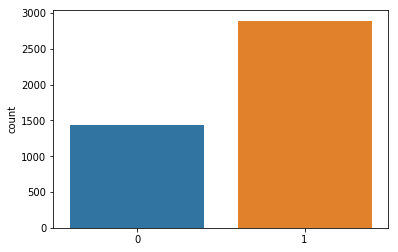

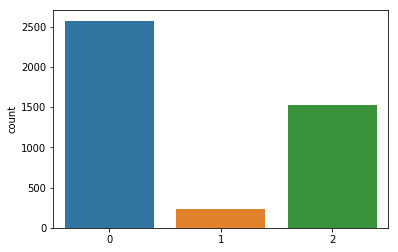

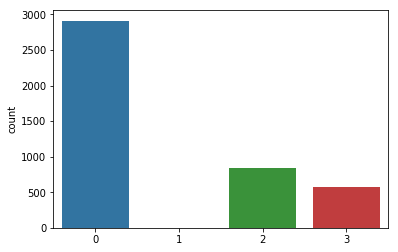

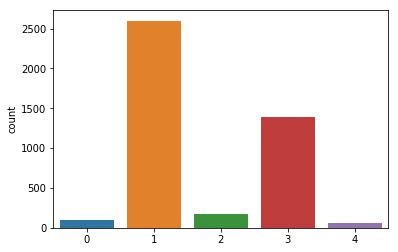

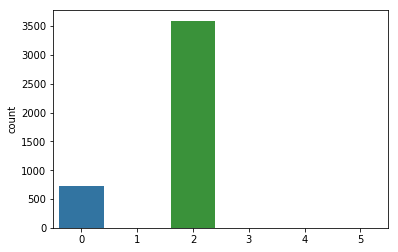

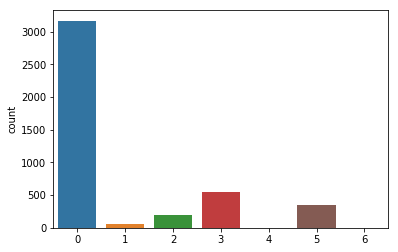

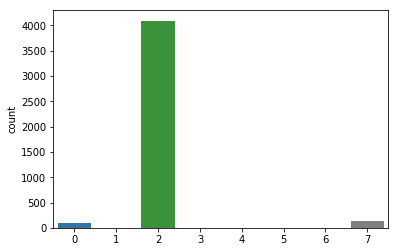

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

for i in Cmb:
    sns.countplot(i)
    plt.show()

## DBSCAN Clustering

In [92]:
from sklearn import cluster

DBScan = cluster.DBSCAN(eps=1)
DBScan.fit(X)
C_DB = DBScan.labels_.astype(np.int)

In [93]:
siluet(X,C_DB)

-0.04039053877190764

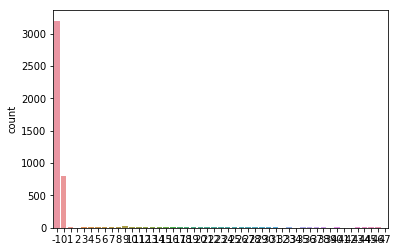

In [94]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(C_DB)
plt.show()

## LDA Clustering

In [15]:
from sklearn.decomposition import LatentDirichletAllocation as LDA

lda=[]
for n_topics in tqdm(range(2,9)):
    model=LDA(n_components=n_topics, learning_method='batch', random_state=0).fit(X)
    lda.append(model)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:48<00:00, 24.05s/it]


In [36]:
vsm_topics=[]
for i in tqdm(lda):
    vsm_topics.append(i.transform(X))
    #ini matriks topik terhadap masing-masing kata 

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.46it/s]


In [37]:
doc_topic=[]
for i in tqdm(range(len(vsm_topics))):
    doc_topic.append([a.argmax()+1 for a in vsm_topics[i]]) # topic of docs

100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 120.76it/s]


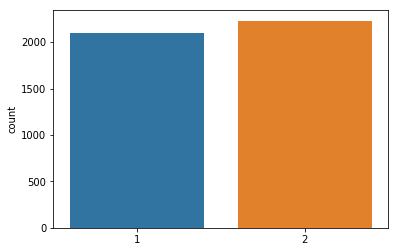

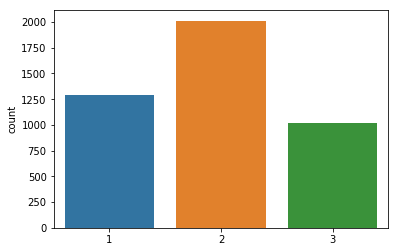

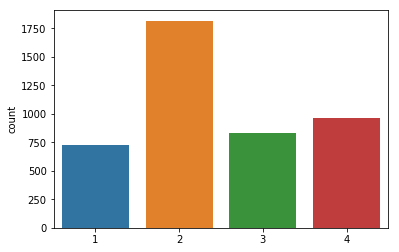

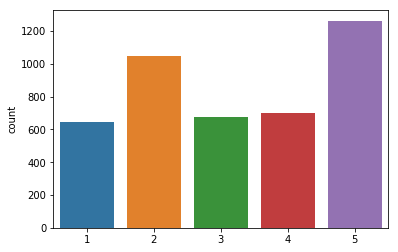

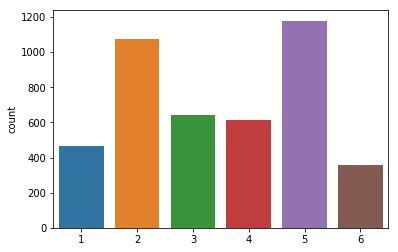

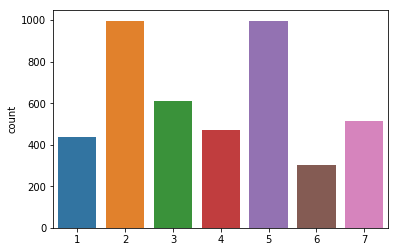

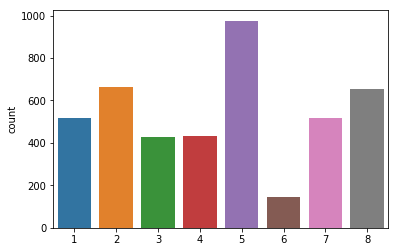

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
for i in doc_topic:
    sns.countplot(i)
    plt.show() 

In [39]:
def print_Topics(model, feature_names, Top_Topics, n_top_words):
    for topic_idx, topic in enumerate(model.components_[:Top_Topics]):
        print("Topic #%d:" %(topic_idx+1))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

Dengan pemodelan LDA yang dilakukan pada masalah komplain pada ISP ,didapat kandidat topic yang menurut peneliti paling bagus berdasarkan plot nya ,yaitu dengan 2 dan 5 topik

In [99]:
# Mari kita coba maknai masing-masing topic ini
Top_Words=15 #ini mau memunculkan berapa banyak kata, untuk memudahkan pendefinisian kelompok
Ntopic=3
print('Printing top {0} Topics, with top {1} Words:'.format(Ntopic, Top_Words))
print_Topics(lda[Ntopic-2], X_terms,Ntopic, Top_Words)

Printing top 3 Topics, with top 15 Words:
Topic #1:
dm tolong respon layan langgan banget ya komplain kali lemot min keluh nya id bales
Topic #2:
pulsa paket min sms kuota ya daftar habis data cek yellow beli rb internet pakai
Topic #3:
sinyal jaring min ya nya kartu nih ganggu hp lemot kah daerah internet banget jelek


In [96]:
Ntopic=2
Vectorized = Tfidf_vectorizer
import pyLDAvis, pyLDAvis.sklearn; pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda[Ntopic-2], X, Vectorized)  

PreparedData(topic_coordinates=            Freq  cluster  topics         x    y
topic                                           
1      53.208455        1       1  0.153935  0.0
0      46.791545        1       2 -0.153935  0.0, topic_info=     Category        Freq        Term       Total  loglift  logprob
term                                                               
914   Default  223.000000       pulsa  223.000000  30.0000  30.0000
842   Default  152.000000       paket  152.000000  29.0000  29.0000
355   Default  124.000000          dm  124.000000  28.0000  28.0000
516   Default   93.000000      jaring   93.000000  27.0000  27.0000
1027  Default   87.000000      sinyal   87.000000  26.0000  26.0000
1043  Default   93.000000         sms   93.000000  25.0000  25.0000
656   Default   60.000000       lemot   60.000000  24.0000  24.0000
161   Default   70.000000      banget   70.000000  23.0000  23.0000
267   Default   62.000000      daftar   62.000000  22.0000  22.0000
275   Default   60.000000        data   60.000000  21.0000  21.0000
427   Default   60.000000       habis   60.000000  20.0000  20.0000
1186  Default   57.000000      yellow   57.000000  19.0000  19.0000
179   Default   56.000000        beli   56.000000  18.0000  18.0000
927   Default   54.000000          rb   54.000000  17.0000  17.0000
632   Default   99.000000       kuota   99.000000  16.0000  16.0000
650   Default   47.000000       layan   47.000000  15.0000  15.0000
407   Default   49.000000          gb   49.000000  14.0000  14.0000
502   Default   49.000000         isi   49.000000  13.0000  13.0000
587   Default   46.000000     kesedot   46.000000  12.0000  12.0000
402   Default   39.000000      ganggu   39.000000  11.0000  11.0000
582   Default   43.000000    kepotong   43.000000  10.0000  10.0000
104   Default   42.000000       aktif   42.000000   9.0000   9.0000
934   Default   41.000000  registrasi   41.000000   8.0000   8.0000
896   Default   43.000000      potong   43.000000   7.0000   7.0000
911   Default   27.000000    provider   27.000000   6.0000   6.0000
851   Default   27.000000       parah   27.000000   5.0000   5.0000
154   Default   27.000000       bales   27.000000   4.0000   4.0000
266   Default   26.000000      daerah   26.000000   3.0000   3.0000
468   Default   27.000000          id   27.000000   2.0000   2.0000
1031  Default   32.000000        sisa   32.000000   1.0000   1.0000
...       ...         ...         ...         ...      ...      ...
223    Topic2   22.836151        buka   23.635831   0.7250  -5.5103
670    Topic2   13.863687      lokasi   14.353875   0.7247  -6.0094
227    Topic2   13.408288       buruk   13.892305   0.7240  -6.0428
869    Topic2   13.484057    perbaiki   13.975712   0.7237  -6.0371
732    Topic2   17.260026      minggu   17.893961   0.7234  -5.7902
151    Topic2   13.758708       bagus   14.269164   0.7230  -6.0170
161    Topic2   67.662263      banget   70.583829   0.7172  -4.4241
834    Topic2   24.099723    operator   25.076292   0.7197  -5.4564
355    Topic2  117.204793          dm  124.331068   0.7004  -3.8747
563    Topic2   26.602894      kecewa   27.765063   0.7167  -5.3576
403    Topic2   29.544029       ganti   31.372362   0.6994  -5.2528
618    Topic2   20.421655    konsumen   21.446770   0.7105  -5.6220
610    Topic2   34.131670    komplain   38.503112   0.6390  -5.1084
570    Topic2   32.280496       keluh   36.673711   0.6319  -5.1642
942    Topic2   39.545307      respon   47.650156   0.5730  -4.9612
787    Topic2   46.151088         nih   61.906966   0.4658  -4.8067
813    Topic2   59.004788         nya   85.215334   0.3919  -4.5610
545    Topic2   51.913966        kali   79.535631   0.3329  -4.6891
258    Topic2   24.684727          cs   27.979895   0.6342  -5.4325
644    Topic2   46.677795     langgan   71.200998   0.3372  -4.7954
1124   Topic2   56.172402      tolong  108.677750   0.0995  -4.6102
541    Topic2   37.866335         kak   58.795429   0.3195  -5.0046
1183   Topic2   59.12

## NMF Clustering

In [42]:
from sklearn.decomposition import NMF

nmf=[]
for n_topics in tqdm(range(2,9)):
    model=NMF(n_components=n_topics, random_state=0).fit(X)
    nmf.append(model)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  3.80it/s]


In [43]:
vsm_topics_nmf=[]
for i in tqdm(nmf):
    vsm_topics_nmf.append(i.transform(X))
    #ini matriks topik terhadap masing-masing kata 

100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 129.71it/s]


In [46]:
doc_topic_nmf=[]
for i in tqdm(range(len(vsm_topics_nmf))):
    doc_topic_nmf.append([a.argmax()+1 for a in vsm_topics_nmf[i]]) # topic of docs

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 59.36it/s]


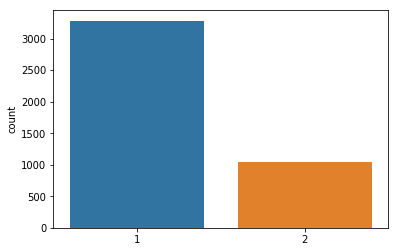

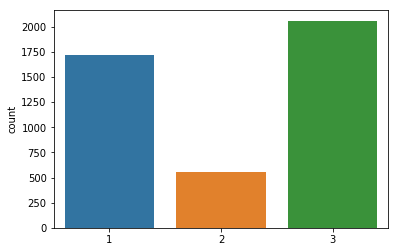

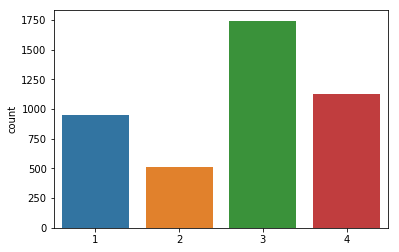

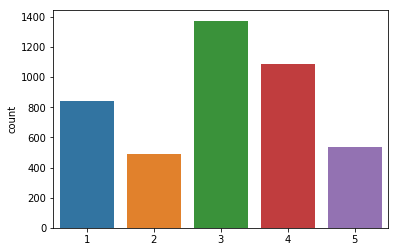

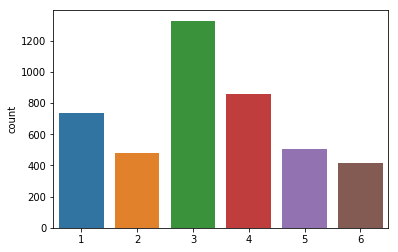

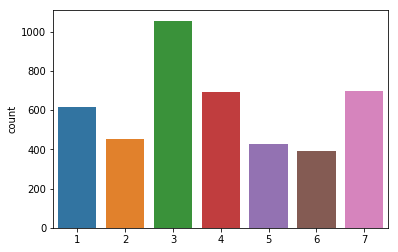

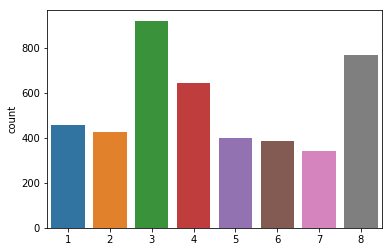

In [47]:
# mari kita plot
import matplotlib.pyplot as plt
import seaborn as sns
for i in doc_topic_nmf:
    sns.countplot(i)
    plt.show() 